# Construct ResNet model

In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import imageio
import scipy
import time
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
import keras
from tensorflow.keras.optimizers import Adadelta, SGD
from keras.models import Sequential, load_model, Model
from keras.layers import Dense, Conv2D, Flatten, MaxPooling2D, Dropout, Input, Add, BatchNormalization, Activation
from keras.initializers import glorot_uniform
from keras.activations import relu, softmax
from keras.callbacks import EarlyStopping, TensorBoard, ModelCheckpoint
from keras.utils.vis_utils import model_to_dot
from keras import backend as K
from sklearn.metrics import confusion_matrix, classification_report
from matplotlib import animation, rc
import matplotlib.patches as mpatches
from IPython.display import HTML, display, clear_output, SVG
import ipywidgets as widgets

import warnings
warnings.filterwarnings("ignore")

if not os.path.exists('models'):
    os.makedirs('models')

In [3]:
# Resuidal block BN -> relu -> conv -> bn -> relu -> conv
def res_block(x, filters):
    bn1 = BatchNormalization()(x)
    act1 = Activation('relu')(bn1)
    conv1 = Conv2D(filters=filters, kernel_size=(3, 3), data_format='channels_last', strides=(2, 2), padding='same', 
                   kernel_initializer=glorot_uniform(seed=0))(act1)

    bn2 = BatchNormalization()(conv1)
    act2 = Activation('relu')(bn2)
    conv2 = Conv2D(filters=filters, kernel_size=(3, 3), data_format='channels_last', strides=(1, 1), padding='same', 
                   kernel_initializer=glorot_uniform(seed=0))(act2)

    residual = Conv2D(1, (1, 1), strides=(1, 1), data_format='channels_last')(conv2)
    
    
    x = Conv2D(filters=filters, kernel_size=(3, 3), data_format='channels_last', strides=(2, 2), padding='same', 
                   kernel_initializer=glorot_uniform(seed=0))(x)

    out = Add()([x, residual])
    
    return out

In [11]:
img_rows, img_cols = 299, 299
input_shape = (img_rows, img_cols, 3)
input1 = Input(shape=(299, 299, 3))

# Combining resuidal blocks into a network
res1 = res_block(input1, 64)
res2 = res_block(res1, 128)
res3 = res_block(res2, 256)
res4 = res_block(res3, 512)

# Classifier block
act1 = Activation('relu')(res4)
flatten1 = Flatten()(act1)
dense1 = Dense(512)(flatten1)
act2 = Activation('relu')(dense1)
dense2 = Dense(1)(act2)
output1 = Activation('sigmoid')(dense2)

model = Model(inputs=input1, outputs=output1)

# Compiling the model
model.compile(loss='binary_crossentropy',
              optimizer=Adadelta(lr=0.01),
              metrics=["acc"])

model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
batch_normalization_16 (BatchNo (None, 299, 299, 3)  12          input_3[0][0]                    
__________________________________________________________________________________________________
activation_22 (Activation)      (None, 299, 299, 3)  0           batch_normalization_16[0][0]     
__________________________________________________________________________________________________
conv2d_32 (Conv2D)              (None, 150, 150, 64) 1792        activation_22[0][0]              
____________________________________________________________________________________________

# Mount Covid Data and view samples

In [5]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)
base_dir = '/content/drive/MyDrive/IISc'


train_dir = os.path.join(base_dir, 'train')
test_dir = os.path.join(base_dir, 'test')

train_covid_dir = os.path.join(train_dir, 'Covid')
train_normal_dir = os.path.join(train_dir, 'Non Covid')

test_covid_dir = os.path.join(test_dir, 'Covid')
test_normal_dir = os.path.join(test_dir, 'Non Covid')

Mounted at /content/drive


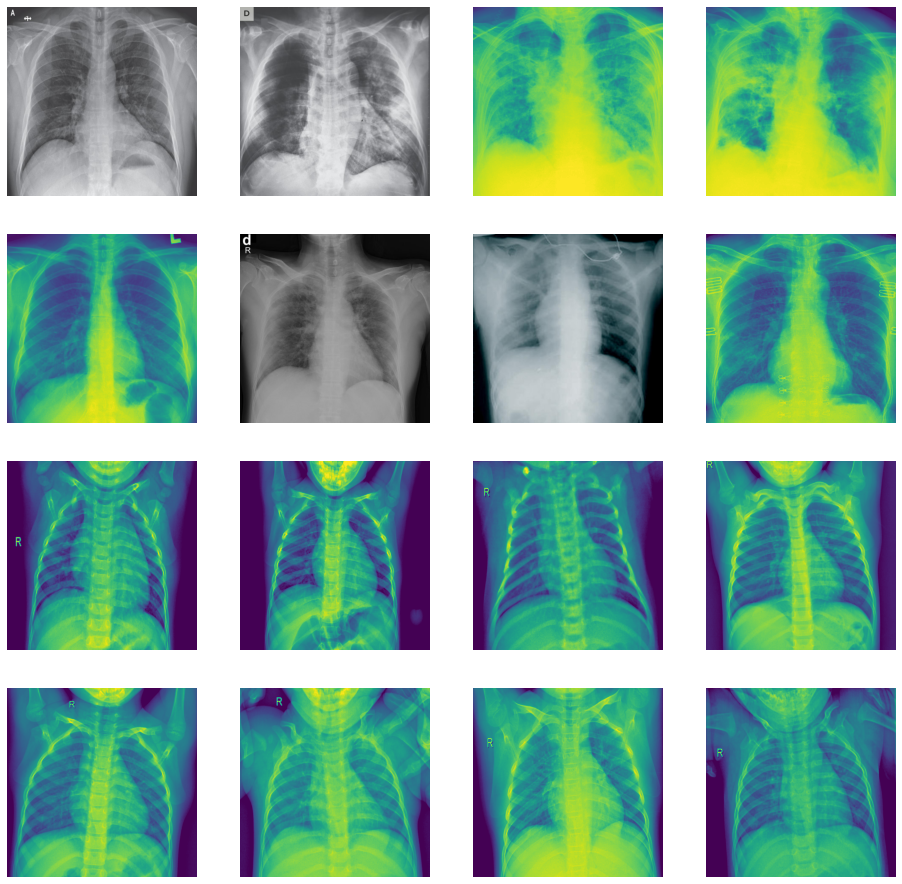

In [6]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt

def verify_data():
  nrows = 4
  ncols = 4

  fig = plt.gcf()
  fig.set_size_inches(ncols*4, nrows*4)
  pic_index = 100
  train_covid_fnames = os.listdir( train_covid_dir )
  train_normal_fnames = os.listdir( train_normal_dir )


  next_covid_pic = [os.path.join(train_covid_dir, fname) 
                for fname in train_covid_fnames[ pic_index-8:pic_index] 
               ]

  next_normal_pic = [os.path.join(train_normal_dir, fname) 
                for fname in train_normal_fnames[ pic_index-8:pic_index]
               ]

  for i, img_path in enumerate(next_covid_pic+next_normal_pic):
    sp = plt.subplot(nrows, ncols, i + 1)
    sp.axis('Off') 
    img = mpimg.imread(img_path)
    plt.imshow(img)

  plt.show()

verify_data()

In [7]:
from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale = 1./255.)
test_datagen = ImageDataGenerator( rescale = 1.0/255. )
train_generator = train_datagen.flow_from_directory(train_dir, 
                                                    batch_size = 50, 
                                                    class_mode = 'binary', 
                                                    target_size = (299, 299), 
                                                    shuffle=True)

test_generator = test_datagen.flow_from_directory(test_dir,  
                                                  batch_size = 10, 
                                                  class_mode = 'binary', 
                                                  target_size = (299, 299))

Found 238 images belonging to 2 classes.
Found 39 images belonging to 2 classes.


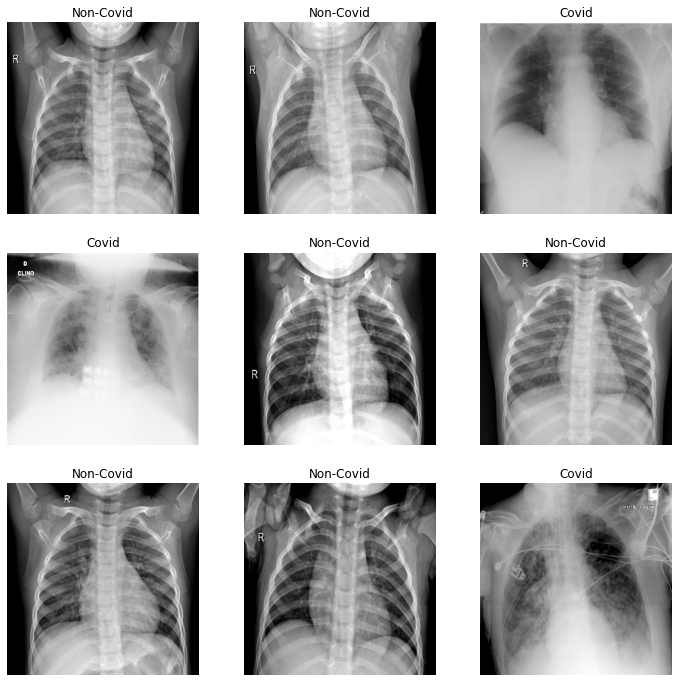

In [8]:
x_batch, y_batch = next(train_generator)
nrows = 3
ncols = 3
fig = plt.gcf()
fig.set_size_inches(ncols*4, nrows*4)

for i in range (0,9):
    sp = plt.subplot(nrows, ncols, i + 1)
    sp.axis('Off') 
    image = x_batch[i]
    plt.imshow(image)
    title = 'Non-Covid'
    if y_batch[i] == 0:
        title = 'Covid'
    plt.title(title)
plt.show()

# Train Model

In [12]:
callback_list = []
train_name = str(int(time.time()))
initial_epoch = 0
if not os.path.exists('model_res/' + train_name):
    os.makedirs('model_res/' + train_name)
model_path="model_res/" + train_name +"/model.hdf5"

callback_list.append(EarlyStopping(monitor='val_loss', patience=1000))
callback_list.append(TensorBoard(log_dir='./logs/res/' + train_name))
callback_list.append(ModelCheckpoint(model_path, period=10, monitor='val_loss', mode='min'))
# model.load_weights('models_res/1537292473/model_160-0.86-0.561555.hdf5')

hist = model.fit_generator(generator=train_generator,
                    validation_data=test_generator,
                    shuffle=True,
                    steps_per_epoch=4,
                    validation_steps=2,
                    epochs=10,
                    initial_epoch=initial_epoch,
                    verbose=1,
                    callbacks=callback_list)

Epoch 1/10
4/4 [==============================] - 169s 41s/step - loss: 0.9870 - acc: 0.6436 - val_loss: 0.6384 - val_acc: 0.8500
Epoch 2/10
4/4 [==============================] - 169s 42s/step - loss: 0.1386 - acc: 0.9681 - val_loss: 0.6387 - val_acc: 0.7500
Epoch 3/10
4/4 [==============================] - 164s 41s/step - loss: 0.0872 - acc: 0.9787 - val_loss: 0.6057 - val_acc: 0.9000
Epoch 4/10
4/4 [==============================] - 180s 46s/step - loss: 0.0497 - acc: 0.9900 - val_loss: 0.6230 - val_acc: 0.9000
Epoch 5/10
4/4 [==============================] - 174s 44s/step - loss: 0.0328 - acc: 1.0000 - val_loss: 0.6033 - val_acc: 0.9500
Epoch 6/10
4/4 [==============================] - 164s 41s/step - loss: 0.0247 - acc: 1.0000 - val_loss: 0.6080 - val_acc: 0.9000
Epoch 7/10
4/4 [==============================] - 180s 46s/step - loss: 0.0216 - acc: 1.0000 - val_loss: 0.6132 - val_acc: 0.8500
Epoch 8/10
4/4 [==============================] - 165s 41s/step - loss: 0.0164 - acc: 1.00

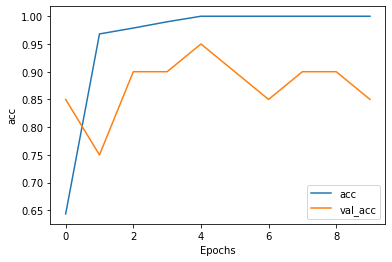

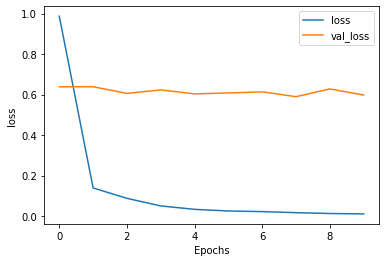

In [13]:
#Visualize Training
def plot_graphs(history, string):
    plt.plot(history.history[string])
    plt.plot(history.history["val_"+string])
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.legend([string,"val_"+string])
    plt.show()
plot_graphs(hist,'acc')
plot_graphs(hist,'loss')

# Evaluate Results

In [14]:
#Accuracy and Loss of Validation Data
loss, accuracy = model.evaluate_generator(test_generator,steps=4,verbose=1)
print("Validation Accuracy: ",accuracy)
print("Validation Loss: ",loss)

4/4 [==============================] - 9s 2s/step - loss: 0.6135 - acc: 0.8718
Validation Accuracy:  0.8717948794364929
Validation Loss:  0.6134667992591858


              precision    recall  f1-score   support

           0       0.80      0.93      0.86        30
           1       0.50      0.22      0.31         9

    accuracy                           0.77        39
   macro avg       0.65      0.58      0.58        39
weighted avg       0.73      0.77      0.73        39



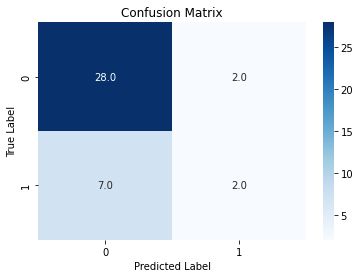

In [15]:
import seaborn as sns

#Getting Predicted Value
Y_pred = model.predict(test_generator,steps=4)
y_pred = np.where(Y_pred>0.5, 1, 0) #np.argmax(Y_pred, axis=1)

print(classification_report(test_generator.classes, y_pred))

confusion = confusion_matrix(test_generator.classes, y_pred)

sns.heatmap(confusion, annot=True,cmap="Blues",fmt='.1f')
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

# Display Misclassified Images

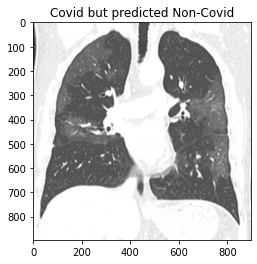

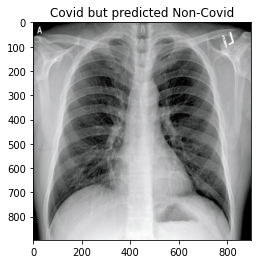

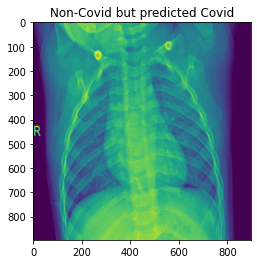

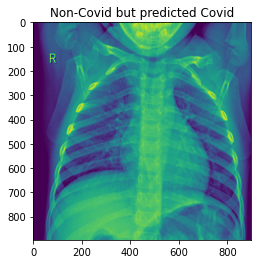

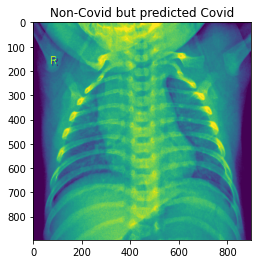

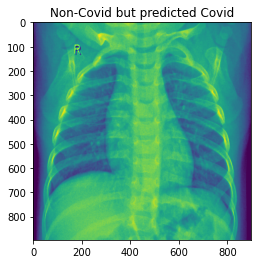

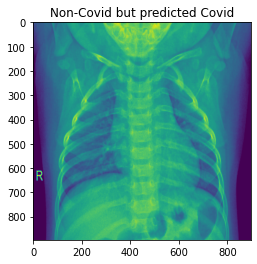

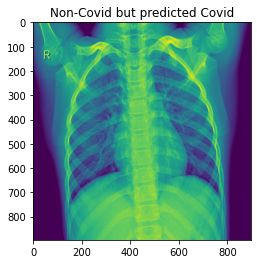

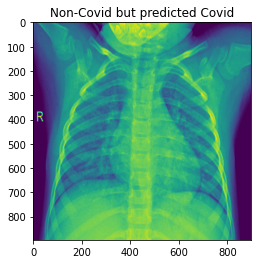

In [30]:
test_covid_fnames = os.listdir( test_covid_dir )
test_normal_fnames = os.listdir( test_normal_dir )

next_covid_pic = sorted([os.path.join(test_covid_dir, fname) 
                for fname in test_covid_fnames])

next_normal_pic = sorted([os.path.join(test_normal_dir, fname) 
                for fname in test_normal_fnames])

test_pics = next_covid_pic + next_normal_pic

for i in range(0, 39):
    if test_generator.classes[i] != y_pred[i]:

      if(y_pred[i] == 1 and test_generator.classes[i] == 0):
        title = "Covid but predicted Non-Covid"
      
      if(y_pred[i] == 0 and test_generator.classes[i] == 1):
        title = 'Non-Covid but predicted Covid'

      sp.axis('Off') 
      img = mpimg.imread(test_pics[i])

      plt.imshow(img)
      plt.title(title)
      plt.show()